## Extract the subjects view

In [1]:
import os
import scipy.io as sio
import numpy as np

In [2]:
def handle_subj_ops(subj):
    subj_file = os.path.join(src_fold, 'subject' + format(subj)+ '.mat')
    data = sio.loadmat(subj_file)['A']
    # eliminate unwanted regions
    #data = data[:, mask]

    #subj_dest_fold = os.path.join(dst_fold, 'subject' + format(subj))
    #os.mkdir(subj_dest_fold)
    return data


In [3]:
def extract_subj_store(subj, data):

    #subj_dest_fold = os.path.join(dst_fold, 'subject' + format(subj))
    #Proceeded by transpose  to obtain 4 matrices for each subject, already checked that it is symmetric
    data=data.transpose(2,0,1)
    #the first matrix (network) in the dataset (over 4)
    #upper_tri=np.triu(data[0])
    matrix=data[0]
    #Vectorize 
    ui=np.triu_indices(35)
    vector=matrix[ui]
    

    #f = os.path.join(subj_dest_fold, 'subjectA'+ format(subj)  + '.mat' )
    ## needed data for classification, labels and features(brain grahps' weights in our case)
    #d = {}
    #d ['vector']=vector
    #sio.savemat(f,d)
    return vector

In [4]:
def create_dataset(subjects,src_fold,dst_fold):
    #subj_dest_fold = os.path.join(dst_fold, 'subject' + format(subj))
    d={}
    Features_vectors=[0 for i in range(630)]
    #v=np.array([[0 for i in range(630)]])
    for subj in subjects:
        subj_data=handle_subj_ops(subj)
        vector=extract_subj_store(subj,subj_data)
        Features_vectors=np.vstack((Features_vectors,vector))
        
        #v=np.append(v,np.array(vector))
        #d['subject'+format(subj)]=vector
    #d['A']=v
    Features_vectors=np.delete(Features_vectors,0,0)
    d['Features_vectors']=Features_vectors
    f = os.path.join(dst_fold, 'Feature_vectors' + '.mat' )
    sio.savemat(f,d)    
    

### --------------------Main------------------------

In [5]:
src_fold  = '/home/raoua/Desktop/BASIRA/working repo/Data_77subjects/LH77subjects/'
label_file = '/home/raoua/Desktop/BASIRA/working repo/Data_77subjects/labels77.mat'
dst_fold = '/home/raoua/Desktop/BASIRA/working repo/intermediate/'

In [6]:
subjects=range(1,78)
#for subj in subjects:
#    # read and create necessary folders
#    subj_data = handle_subj_ops(subj)
#    extract_subj_store(subj, subj_data)
create_dataset(subjects,src_fold,dst_fold)

### Start over here 

In [1]:
import scipy.io as sio

In [2]:
Data=sio.loadmat('./intermediate/Feature_vectors.mat')

In [3]:
X=Data['Features_vectors']

In [4]:
X = X.astype(float)

In [5]:
labels=sio.loadmat('./labels77.mat')

In [6]:
y=labels['labels']

In [7]:
X.dtype

dtype('float64')

### Feature selection

In [8]:
y=y[:, 0]

In [9]:
 n_samples, n_features = X.shape    # number of samples and number of features

In [10]:
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import accuracy_score
from skfeature.function.similarity_based import reliefF

### 5-fold

In [11]:
# split data into 5 folds
kf=KFold(n_splits=5,shuffle=True)

#ss = cross_validate(n_samples, n_folds=5, shuffle=True)

In [12]:
kf.get_n_splits(X)

5

In [13]:
# Number of selected features (top k ranked features)

#top K selected features varying from 10 to 100 (with a step size of 10 features)
num_fea = [i for i in range(10,110,10)]
clf = svm.LinearSVC()    # linear SVM
correct=0
accuracy=[]

In [14]:
len(num_fea)

10

In [15]:
for k in num_fea: 
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # obtain the score of each feature on the training set
        #score = reliefF.reliefF(X_train, y_train)
        score=FS_method.FS_method(X_train,y_train)
        # rank features in descending order according to score
        idx = reliefF.feature_ranking(score)
        # obtain the dataset on the selected features
        selected_features = X[:, idx[0:k]]
        # train a classification model with the selected features on the training dataset
        clf.fit(selected_features[train_index], y[train_index])
        # predict the class labels of test data
        y_predict = clf.predict(selected_features[test_index])
        # obtain the classification accuracy on the test data
        acc = accuracy_score(y[test_index], y_predict)
        #correct = correct + acc
    #accuracy.append(float(correct)/10)
    accuracy.append(acc)
    

# output the average classification accuracy over all 10 folds
print ('Accuracy:', accuracy)

Accuracy: [0.7333333333333333, 0.6666666666666666, 0.6666666666666666, 0.8, 0.5333333333333333, 0.6, 0.6, 0.6666666666666666, 0.7333333333333333, 0.6666666666666666, 0.7333333333333333, 0.6666666666666666, 0.6, 0.4666666666666667, 0.6666666666666666, 0.7333333333333333, 0.6, 0.6666666666666666, 0.5333333333333333, 0.6]


In [17]:
max(accuracy)

0.8

In [15]:
#MutInfFS
from skfeature.function.information_theoretical_based import MIFS
#laplacian
from skfeature.function.similarity_based import lap_score
from skfeature.utility import construct_W
# norm
from skfeature.function.sparse_learning_based import ll_l21
from skfeature.utility.sparse_learning import *
#UDFS
from skfeature.function.sparse_learning_based import UDFS
from skfeature.utility.sparse_learning import feature_ranking
#cFS(correlation based FS)
from skfeature.function.statistical_based import CFS

In [16]:
def relief_FS(X_train,y_train):
    score=reliefF.reliefF(X_train,y_train)
    idx=reliefF.feature_ranking(score)
    return(idx)

In [17]:
def MIFS_FS(k,X_train,y_train):
    idx = MIFS.mifs(X_train, y_train, n_selected_features=k)
    print(idx)
    return(idx)

In [18]:
def lap_score_FS():
    # construct affinity matrix
    kwargs_W = {"metric": "euclidean", "neighbor_mode": "knn", "weight_mode": "heat_kernel", "k": 5, 't': 1}
    W = construct_W.construct_W(X, **kwargs_W)
    # obtain the scores of features
    score = lap_score.lap_score(X, W=W)
    idx=lap_score.feature_ranking(score)
    return(idx)

In [19]:
def ll_l21_FS(X_train,y,train_index):
    Y = construct_label_matrix_pan(y)
    Y_train=Y[train_index]
    Weight, obj, value_gamma = ll_l21.proximal_gradient_descent(X_train, Y[train_index], 0.1, verbose=False)
    idx = feature_ranking(Weight)
    return(idx)
    
    

In [20]:
def UDFS_FS():
    Weight = UDFS.udfs(X)
    idx=feature_ranking(Weight)
    return(idx)
    

In [21]:
def CFS_FS(X_train,y_train):
    idx = CFS.cfs(X_train, y_train)
    return(idx)
    

In [22]:
def training(num_fea,FS_method):
    accuracy=[]
    for k in num_fea: 
        for train_index, test_index in kf.split(X):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
 
            if FS_method==reliefF:
                idx=relief_FS(X_train,y_train)
            elif FS_method==MIFS:
                idx=MIFS_FS(k,X_train,y_train)
            elif FS_method==lap_score:
                idx=lap_score_FS()
            elif FS_method==ll_l21:
                idx=ll_l21_FS(X_train,y,train_index)
            elif FS_method==UDFS:
                idx=UDFS_FS()
            elif FS_method==CFS:
                idx=CFS_FS(X_train,y_train)
            selected_features = X[:, idx[0:k]]
            # train a classification model with the selected features on the training dataset
            clf.fit(selected_features[train_index], y[train_index])
            # predict the class labels of test data
            y_predict = clf.predict(selected_features[test_index])
            # obtain the classification accuracy on the test data
            acc = accuracy_score(y[test_index], y_predict)
            #correct = correct + acc
        #accuracy.append(float(correct)/10)
        accuracy.append(acc)
    return(accuracy)

In [23]:
test=training(num_fea,CFS)

In [25]:
CFS_accuracy=test

In [59]:
def main():
    
Pool_FS=[reliefF,MIFS,lap_score,ll_l21,UDFS]

In [60]:
performance=[]
for FS in Pool_FS:
    performance.append(training(num_fea,FS))

TypeError: 'str' object is not callable

### Plot the results

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

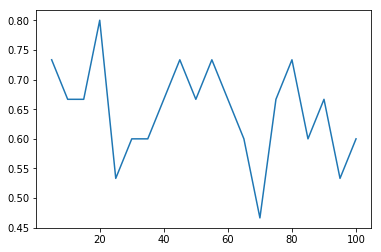

In [20]:
plt.plot(num_fea,accuracy)

In [21]:
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


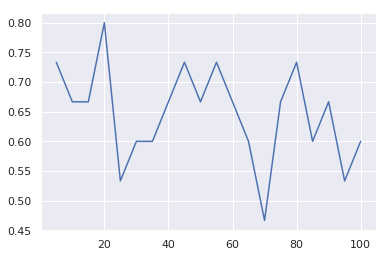

In [22]:
plt.plot(num_fea,accuracy)


#### Interpretation: The maximum accuracy=0.8 is reached when number of selected features=20

#### Understand the pipeline

In [7]:
# values between -0.5 and 0.5
max_principle_curveture=data.transpose(2,1,0)[0]

In [9]:
#values between 0 and 4
mean_cortical_thickness=data.transpose(2,1,0)[1]

In [14]:
mean_cortical_thickness.max()

3.47458

In [22]:
sulcal_depth=data.transpose(2,1,0)[2]

In [24]:
sulcal_depth.max()

1.18138

In [34]:
a=[[1,2,3],[2,3,4],[5,6,7],[8,9,10]]
#b=[2,3,4]
#c=[5,6,7]
#d=[8,9,10]
matrix=[[0,0,0]]
for vector in a:
    matrix=np.vstack((matrix,vector))
    #print(vector)
print(matrix)

[[ 0  0  0]
 [ 1  2  3]
 [ 2  3  4]
 [ 5  6  7]
 [ 8  9 10]]


In [47]:
new_matrix=np.delete(matrix,0 , 0)

In [48]:
new_matrix

array([[ 1,  2,  3],
       [ 2,  3,  4],
       [ 5,  6,  7],
       [ 8,  9, 10]])

In [6]:
np.vstack((array2D_1, array2D_2))

In [12]:
A['vector'].shape

(1, 630)

How to build FS-to-FS matrices modelling the overlap of top K ranked features ??

In [10]:
A=np.array([[[ 4.,  9., -3.],
       [ 2.,  4., -2.]],
            [[ 3.,  7., -6.],
       [ 0,  4., -2.]],
            [[ 4.,  9., -3.],
       [ 2.,  4., -2.]],
            [[ 4.,  9., -3.],
       [ 2.,  4., -2.]]])

In [16]:
A=np.array([[ 4.,  9., -3.],
       [ 2.,  4., -2.],
            [ 3.,  7., -6.]])

In [18]:
B=np.triu(A)

In [19]:
B.flatten()

array([ 4.,  9., -3.,  0.,  4., -2.,  0.,  0., -6.])

In [20]:
iu1 = np.triu_indices()

In [22]:
#A.transpose(2,1,0).reshape(3,-1)
B

array([[ 4.,  9., -3.],
       [ 0.,  4., -2.],
       [ 0.,  0., -6.]])

In [26]:
iu1=np.triu_indices(3)

In [27]:
A[iu1]

array([ 4.,  9., -3.,  4., -2., -6.])

#### Each subject have four matrices of size (35,35)

In [77]:
subj_data.shape

(35, 35, 4)

In [96]:
data[0]

array([[0.       , 0.0868267, 0.143509 , ..., 0.       , 0.180633 ,
        0.0345723],
       [0.0868267, 0.       , 0.0566822, ..., 0.0868267, 0.0938058,
        0.0522545],
       [0.143509 , 0.0566822, 0.       , ..., 0.143509 , 0.0371236,
        0.108937 ],
       ...,
       [0.       , 0.0868267, 0.143509 , ..., 0.       , 0.180633 ,
        0.0345723],
       [0.180633 , 0.0938058, 0.0371236, ..., 0.180633 , 0.       ,
        0.14606  ],
       [0.0345723, 0.0522545, 0.108937 , ..., 0.0345723, 0.14606  ,
        0.       ]])

In [93]:
data=subj_data.transpose(2,0,1)

In [94]:
data.shape

(4, 35, 35)

In [104]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [105]:
check_symmetric(data[0])

True

#### Extract the off-diagonal upper triangular part of its matrix

In [88]:
np.triu(data[0])

array([[0.       , 0.0868267, 0.143509 , ..., 0.       , 0.180633 ,
        0.0345723],
       [0.       , 0.       , 0.0566822, ..., 0.0868267, 0.0938058,
        0.0522545],
       [0.       , 0.       , 0.       , ..., 0.143509 , 0.0371236,
        0.108937 ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.180633 ,
        0.0345723],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.14606  ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]])

In [ ]:
##Vectorize

In [89]:
np.triu(data[1])

array([[0.      , 2.43344 , 2.31531 , ..., 0.      , 2.53488 , 3.02735 ],
       [0.      , 0.      , 0.118135, ..., 2.43344 , 0.101441, 0.593906],
       [0.      , 0.      , 0.      , ..., 2.31531 , 0.219576, 0.712042],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 2.53488 , 3.02735 ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.492465],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])

In [90]:
np.triu(data[2])

array([[0.      , 0.263825, 0.145121, ..., 0.      , 0.449162, 0.63097 ],
       [0.      , 0.      , 0.118704, ..., 0.263825, 0.185338, 0.367146],
       [0.      , 0.      , 0.      , ..., 0.145121, 0.304042, 0.485849],
       ...,
       [0.      , 0.      , 0.      , ..., 0.      , 0.449162, 0.63097 ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.181808],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]])